## Cross-Validation

Having discussed the fundamentals of supervised and unsupervised learning, and having explored a variety of machine learning algorithms, we will now dive more deeply into evaluating models and selecting parameters.

We will focus on the supervised methods, regression and classification, as evaluating and selecting models in unsupervised learning is often a very qualitative process.

To evaluate our supervised models, so far we have split our dataset into a training set and a test set using the *train_test_split* function, built a model on the training set by calling the *fit* method, and evaluated it on the test set using the *score* method, which for classification computes the fraction of correctly classified samples. Here’s an example of that process:

In [3]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn
from IPython.display import display
import mglearn

# Don't display deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Create a synthetic dataset
X, y = make_blobs(random_state=0)

# Split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Instantiate a model and fit it to the training set
logreg = LogisticRegression().fit(X_train, y_train)

# Evaluate the model on the test set
print("Test set score: {:.2f}".format(logreg.score(X_test, y_test)))

Test set score: 0.88


Remember, the reason we split our data into training and test sets is that we are interested in measuring how well our model generalizes to new, previously unseen data. We are not interested in how well our model fit the training set, but rather in how well it can make predictions for data that was not observed during training.

In this chapter, we will expand on two aspects of this evaluation. We will first introduce *cross-validation*, a more robust way to assess generalization performance, and discuss methods to evaluate classification and regression performance that go beyond the default measures of accuracy and R2 provided by the score method.

We will also discuss *grid search*, an effective method for adjusting the parameters in supervised models for the best generalization performance. 

### Cross-Validation

*Cross-validation* is a statistical method of evaluating generalization performance that is more stable and thorough than using a split into a training and a test set. In cross-validation, the data is instead split repeatedly and multiple models are trained. 

The most commonly used version of cross-validation is *k-fold cross-validation*, where k is a user-specified number, usually 5 or 10. When performing five-fold cross-validation, the data is first partitioned into five parts of (approximately) equal size, called *folds*. 

Next, a sequence of models is trained. The first model is trained using the first fold as the test set, and the remaining folds (2–5) are used as the training set. The model is built using the data in folds 2–5, and then the accuracy is evaluated on fold 1. Then another model is built, this time using fold 2 as the test set and the data in folds 1, 3, 4, and 5 as the training set. This process is repeated using folds 3, 4, and 5 as test sets. For each of these five splits of the data into training and test sets, we compute the accuracy. In the end, we have collected five accuracy values. 

The process is illustrated here:

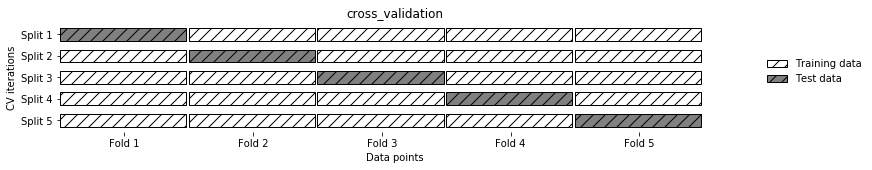

In [5]:
mglearn.plots.plot_cross_validation()

Usually, the first fifth of the data is the first fold, the second fifth of the data is the second fold, and so on.

### Cross-Validation in scikit-learn

Cross-validation is implemented in *scikit-learn* using the *cross_val_score* function from the *model_selection* module. The parameters of the *cross_val_score* function are the model we want to evaluate, the training data, and the ground-truth labels. Let’s evaluate *LogisticRegression* on the *iris* dataset:

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression()

scores = cross_val_score(logreg, iris.data, iris.target)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96078431 0.92156863 0.95833333]


Here, *cross_val_score* performed three-fold cross-validation and therefore returned three scores. By default, *cross_val_score* performs three-fold cross-validation in earlier versions of scikit-learn, and will perform five-fold cross-validation by default (starting with scikit-learn 0.22). We can change the number of folds used by changing the *cv* parameter:

In [7]:
scores = cross_val_score(logreg, iris.data, iris.target, cv=5)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [1.         0.96666667 0.93333333 0.9        1.        ]


It’s recommended to use at least five-fold cross-validation. A common way to summarize the cross-validation accuracy is to compute the mean:

In [8]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.96


Using the mean cross-validation we can conclude that we expect the model to be around 96% accurate on average. Looking at all five scores produced by the five-fold cross-validation, we can also conclude that there is a relatively high variance in the accuracy between folds, ranging from 100% accuracy to 90% accuracy. This could imply that the model is very dependent on the particular folds used for training, but it could also just be a consequence of the small size of the dataset. 

There is a second function you can use for cross-validation, called *cross_validate*. It has a similar interface to *cross_val_score*, but returns a dictionary containing training and test times (and optionally the training score, in addition to the test scores) for each split:

In [9]:
from sklearn.model_selection import cross_validate

res = cross_validate(logreg, iris.data, iris.target, cv=5, return_train_score=True)
display(res)

{'fit_time': array([0.00241542, 0.00135422, 0.0014441 , 0.00125861, 0.0011785 ]),
 'score_time': array([0.00049329, 0.00047708, 0.00048161, 0.00040293, 0.00038767]),
 'test_score': array([1.        , 0.96666667, 0.93333333, 0.9       , 1.        ]),
 'train_score': array([0.95      , 0.96666667, 0.96666667, 0.975     , 0.95833333])}

Using pandas, we can nicely display these results and compute summaries:

In [10]:
res_df = pd.DataFrame(res)
display(res_df)

print("Mean times and scores:\n", res_df.mean())

,fit_time,score_time,test_score,train_score
0,0.002415,0.000493,1.000000,0.950000
1,0.001354,0.000477,0.966667,0.966667
2,0.001444,0.000482,0.933333,0.966667
3,0.001259,0.000403,0.900000,0.975000
4,0.001179,0.000388,1.000000,0.958333


Mean times and scores:
 fit_time       0.001530
score_time     0.000449
test_score     0.960000
train_score    0.963333
dtype: float64


### Benefits of Cross-Validation

There are several benefits to using cross-validation instead of a single split into a training and a test set. First, remember that *train_test_split* performs a random split of the data. Imagine that we are “lucky” when randomly splitting the data, and all examples that are hard to classify end up in the training set. In that case, the test set will only contain “easy” examples, and our test set accuracy will be unrealistically high. Conversely, if we are “unlucky,” we might have randomly put all the hard-to-classify examples in the test set and consequently obtain an unrealistically low score. However, when using cross-validation, each example will be in the test set exactly once: each example is in one of the folds, and each fold is the test set once. Therefore, the model needs to generalize well to all of the samples in the dataset for all of the cross-validation scores (and their mean) to be high.

Having multiple splits of the data also provides some information about how sensitive our model is to the selection of the training dataset. For the *iris* dataset, we saw accuracies between 90% and 100%. This is quite a range, and it provides us with an idea about how the model might perform in the worst case and best case scenarios when applied to new data.

Another benefit of cross-validation as compared to using a single split of the data is that we use our data more effectively. When using train_test_split, we usually use 75% of the data for training and 25% of the data for evaluation. When using five-fold cross-validation, in each iteration we can use four-fifths of the data (80%) to fit the model. When using 10-fold cross-validation, we can use nine-tenths of the data (90%) to fit the model. More data will usually result in more accurate models.

The main disadvantage of cross-validation is increased computational cost. As we are now training k models instead of a single model, cross-validation will be roughly k times slower than doing a single split of the data.

Note that it is important to keep in mind that cross-validation is not a way to build a model that can be applied to new data. Cross-validation does not return a model. When calling *cross_val_score*, multiple models are built internally, but the purpose of cross-validation is only to evaluate how well a given algorithm will generalize when trained on a specific dataset.

### Stratified k-Fold Cross-Validation and Other Strategies

Splitting the dataset into k folds by starting with the first one-k-th part of the data, as described in the previous section, might not always be a good idea. For example, let’s have a look at the iris dataset:

In [11]:
from sklearn.datasets import load_iris
iris = load_iris()

print("Iris labels:\n{}".format(iris.target))

Iris labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


As you can see, the first third of the data is the class 0, the second third is the class 1, and the last third is the class 2. Imagine doing three-fold cross-validation on this dataset. The first fold would be only class 0, so in the first split of the data, the test set would be only class 0, and the training set would be only classes 1 and 2. As the classes in training and test sets would be different for all three splits, the three-fold cross-validation accuracy would be zero on this dataset. That is not very helpful, as we can do much better than 0% accuracy on iris.

As the simple k-fold strategy fails here, scikit-learn does not use it for classification, but rather uses *stratified k-fold cross-validation*. In stratified cross-validation, we split the data such that the proportions between classes are the same in each fold as they are in the whole dataset, as illustrated here:

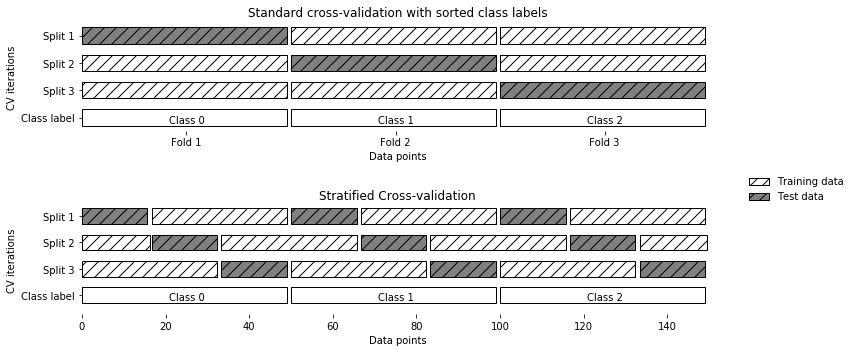

In [12]:
mglearn.plots.plot_stratified_cross_validation()

For example, if 90% of your samples belong to class A and 10% of your samples belong to class B, then stratified cross-validation ensures that in each fold, 90% of samples belong to class A and 10% of samples belong to class B.

It is usually a good idea to use stratified k-fold cross-validation instead of k-fold cross-validation to evaluate a classifier, because it results in more reliable estimates of generalization performance. In the case of only 10% of samples belonging to class B, using standard k-fold cross-validation it might easily happen that one fold only contains samples of class A. Using this fold as a test set would not be very informative about the overall performance of the classifier.

For regression, scikit-learn uses the standard k-fold cross-validation by default. It would be possible to also try to make each fold representative of the different values the regression target has, but this is not a commonly used strategy and would be surprising to most users.

### More Control Over Cross Validation

We saw earlier that we can adjust the number of folds that are used in *cross_val_score* using the *cv* parameter. However, scikit-learn allows for much finer control over what happens during the splitting of the data by providing a *cross-validation splitter* as the *cv* parameter. 

For most use cases, the defaults of k-fold cross-validation for regression and stratified k-fold for classification work well, but there are some cases where you might want to use a different strategy. Say, for example, we want to use the standard k-fold cross-validation on a classification dataset to reproduce someone else’s results. To do this, we first have to import the *KFold* splitter class from the *model_selection* module and instantiate it with the number of folds we want to use:

In [13]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

Then, we can pass the *kfold* splitter object as the *cv* parameter to *cross_val_score*:

In [14]:
print("Cross-validation scores:\n{}".format(
      cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[1.         0.93333333 0.43333333 0.96666667 0.43333333]


This way, we can verify that it is indeed a really bad idea to use three-fold (nonstratified) cross-validation on the *iris* dataset:

In [15]:
kfold = KFold(n_splits=3)
print("Cross-validation scores:\n{}".format(
    cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[0. 0. 0.]


Remember: each fold corresponds to one of the classes in the *iris* dataset, and so nothing can be learned. Another way to resolve this problem is to shuffle the data instead of stratifying the folds, to remove the ordering of the samples by label. We can do that by setting the *shuffle* parameter of *KFold* to *True*. If we shuffle the data, we also need to fix the *random_state* to get a reproducible shuffling. Otherwise, each run of *cross_val_score* would yield a different result, as each time a different split would be used (this might not be a problem, but can be surprising). Shuffling the data before splitting it yields a much better result:

In [16]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print("Cross-validation scores:\n{}".format(
    cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[0.9  0.96 0.96]


### Leave-One-Out Cross Validation

Another frequently used cross-validation method is *leave-one-out*. You can think of leave-one-out cross-validation as k-fold cross-validation where each fold is a single sample. For each split, you pick a single data point to be the test set. This can be very time consuming, particularly for large datasets, but sometimes provides better estimates on small datasets:

In [17]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)

print("Number of cv iterations: ", len(scores))
print("Mean accuracy: {:.2f}".format(scores.mean()))

Number of cv iterations:  150
Mean accuracy: 0.95


### Shuffle-Split Cross-Validation

Another, very flexible strategy for cross-validation is *shuffle-split cross-validation*. In shuffle-split cross-validation, each split samples *train_size* many points for the training set and test_size many (disjoint) point for the test set. This splitting is repeated *n_splits* times. 

This diagram illustrates running four iterations of splitting a dataset consisting of 10 points, with a training set of 5 points and test sets of 2 points each (you can use integers for *train_size* and *test_size* to use absolute sizes for these sets, or floating-point numbers to use fractions of the whole dataset):

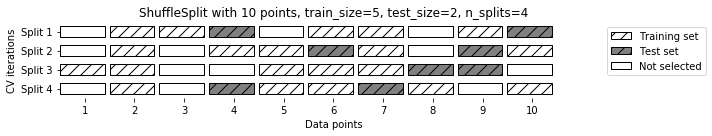

In [18]:
mglearn.plots.plot_shuffle_split()

The following code splits the dataset into 50% training set and 50% test set for 10 iterations:

In [19]:
from sklearn.model_selection import ShuffleSplit

shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)

print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[0.93333333 0.96       0.89333333 0.90666667 0.93333333 0.86666667
 0.89333333 0.94666667 0.94666667 0.93333333]


Shuffle-split cross-validation allows for control over the number of iterations independently of the training and test sizes, which can sometimes be helpful. It also allows for using only part of the data in each iteration, by providing *train_size* and *test_size* settings that don’t add up to one. Subsampling the data in this way can be useful for experimenting with large datasets.

There is also a stratified variant of *ShuffleSplit*, aptly named *StratifiedShuffleSplit*, which can provide more reliable results for classification tasks.

### Cross-Validation With Groups